# 2018 Data Science Bowl
## Find the nuclei in divergent images to advance medical discovery

다양한 이미지의 핵으로 부터 의료 발전을 찾습니다.

폐암 및 심장 질환에서 드문 질환에 이르는 거의 모든 질병에 대한 연구 속도를 상상해보세요. 2018 Data Science Bowl에서 핵 검출을 자동화하는 알고리즘을 만들어 보세요.

우리는 암, 심장병, 만성 폐색 성 폐 질환, 알츠하이머 및 당뇨병과 같은 질병으로 고통받는 사람들을 모두 목격했어요. 많은 사람들이 사랑하는 사람이 떠나가는 것을 보았어요. 치료가 더 빨리 이루어질 경우 얼마나 많은 삶이 달라질 수 있을지 생각해보세요.

핵 검출을 자동화함으로써 희귀 질환에서부터 감기에 이르기까지 신속하게 치료제를 출시 할 수 있을 거예요.


## 이미지 처리 튜토리얼

이 커널은 고전적인 이미지 처리 기술을 구현하며, 이전에 이미지로 데이터를 작업해본적이 없는 입문자들에게 적당합니다. 궁극적으로 우리는 테스트 이미지에 적용할 수 있는 scipy와 numpy (그리고 약간의 scikit 이미지)를 사용하여 간단한 파이프 라인을 개발합니다. 이 커널은 분석을 높이는 것보다 이미지에 익숙하지 않는 사람들을 돕기위한 목적입니다.

출처 : https://www.kaggle.com/stkbailey/teaching-notebook-for-total-imaging-newbies

In [1]:
import pathlib
import imageio
import numpy as np

training_paths = pathlib.Path('data/stage1_train').glob('*/images/*.png')
training_sorted = sorted([x for x in training_paths])
im_path = training_sorted[45]
im = imageio.imread(str(im_path))

### Dealing with color

이 데이터 세트의 이미지는 RGB, RGBA 및 그레이 스케일 형식이 될 수 있습니다. 컬러 이미지의 경우 "채널"(예 : 빨강, 초록, 파랑)을 인코딩하는 세 번째 차원이 있습니다. 이 첫 번째 단계에서 작업을 단순화하기 위해 scikit-image의 rgb2gray 함수를 사용하여 모든 이미지를 그레이 스케일로 강제 변환 할 수 있습니다.

In [2]:
# Print the image dimensions
print('Original image shape: {}'.format(im.shape))

# Coerce the image into grayscale format (if not already)
from skimage.color import rgb2gray
im_gray = rgb2gray(im)
print('New image shape: {}'.format(im_gray.shape))

Original image shape: (520, 696, 4)
New image shape: (520, 696)


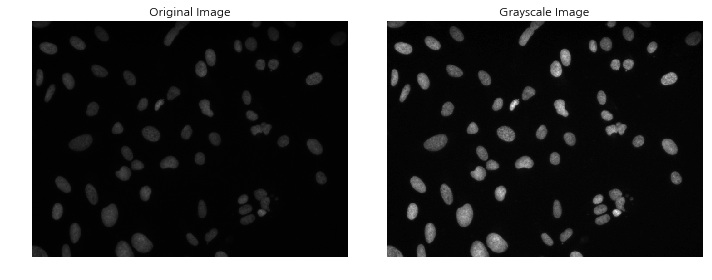

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.imshow(im)
plt.axis('off')
plt.title('Original Image')

plt.subplot(1,2,2)
plt.imshow(im_gray, cmap='gray')
plt.axis('off')
plt.title('Grayscale Image')

plt.tight_layout()
plt.show()

### Removing background

In [4]:
from skimage.filters import threshold_otsu
thresh_val = threshold_otsu(im_gray)
mask = np.where(im_gray > thresh_val, 1, 0)

# 마스크의 큰 부분이 배경으로 보여지는지 확인해요.
if np.sum(mask==0) < np.sum(mask==1):
    mask = np.where(mask, 0, 1)

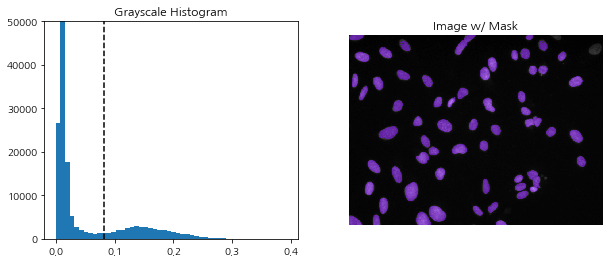

In [5]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
im_pixels = im_gray.flatten()
plt.hist(im_pixels,bins=50)
plt.vlines(thresh_val, 0, 100000, linestyle='--')
plt.ylim([0,50000])
plt.title('Grayscale Histogram')

plt.subplot(1,2,2)
mask_for_display = np.where(mask, mask, np.nan)
plt.imshow(im_gray, cmap='gray')
plt.imshow(mask_for_display, cmap='rainbow', alpha=0.5)
plt.axis('off')
plt.title('Image w/ Mask')

plt.show()

### Deriving individual masks for each object
* 각 객체에서 개별 마스크 추출하기
이 대회에서는 각 핵에 대해 별도의 마스크를 얻어야 합니다. 연결되어있는 마스크의 모든 객체를 찾고 `ndimage.label`을 사용하여 각 객체에 번호를 할당합니다. 그리고 각 `label_id`를 반복하여 리스트와 같은 반복 가능한 목록에 추가합니다.

In [6]:
from scipy import ndimage
labels, nlabels = ndimage.label(mask)

label_arrays = []
for label_num in range(1, nlabels+1):
    label_mask = np.where(labels == label_num, 1, 0)
    label_arrays.append(label_mask)

print('There are {} separate components / objects detected.'.format(nlabels))

There are 76 separate components / objects detected.


[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [75. 75. 75. ... nan nan nan]
 [75. 75. 75. ... nan nan nan]
 [75. 75. 75. ... nan nan nan]]


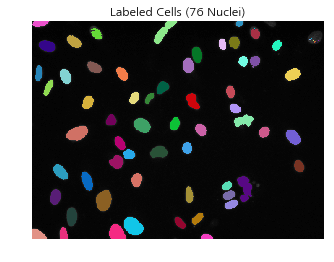

In [7]:
# 랜덤 컬러맵 생성
from matplotlib.colors import ListedColormap
rand_cmap = ListedColormap(np.random.rand(256,3))

labels_for_display = np.where(labels > 0, labels, np.nan)
print(labels_for_display)

plt.imshow(im_gray, cmap='gray')
plt.imshow(labels_for_display, cmap=rand_cmap)
plt.axis('off')
plt.title('Labeled Cells ({} Nuclei)'.format(nlabels))
plt.show()

빠르게 살펴보면 이 단순한 이미지는 2개의 문제를 드러냅니다. 
- 오른쪽 상단처럼 몇 개의 개별 픽셀이 있습니다. 
- 상단의 중간에 있는 일부 셀은 단일 마스크로 결합됩니다. 

ndimage.find_objects를 사용하여 마스크를 통해 반복 할 수 있으며 추가 처리 단계를 적용하기 위해 발견 된 개별 핵을 확대 할 수 있습니다. find_objects는 이미지의 각 레이블 된 객체에 대한 좌표 범위 목록을 반환합니다.

In [8]:
for label_ind, label_coords in enumerate(ndimage.find_objects(labels)):
    cell = im_gray[label_coords]
    
    # Check if the label size is too small
    if np.product(cell.shape) < 10: 
        print('Label {} is too small! Setting to 0.'.format(label_ind))
        mask = np.where(labels==label_ind+1, 0, mask)

# Regenerate the labels
labels, nlabels = ndimage.label(mask)
print('There are now {} separate components / objects detected.'.format(nlabels))

Label 4 is too small! Setting to 0.
Label 5 is too small! Setting to 0.
Label 7 is too small! Setting to 0.
Label 8 is too small! Setting to 0.
Label 9 is too small! Setting to 0.
Label 10 is too small! Setting to 0.
Label 14 is too small! Setting to 0.
Label 15 is too small! Setting to 0.
Label 16 is too small! Setting to 0.
Label 19 is too small! Setting to 0.
Label 21 is too small! Setting to 0.
Label 22 is too small! Setting to 0.
Label 23 is too small! Setting to 0.
Label 60 is too small! Setting to 0.
Label 61 is too small! Setting to 0.
Label 72 is too small! Setting to 0.
There are now 60 separate components / objects detected.


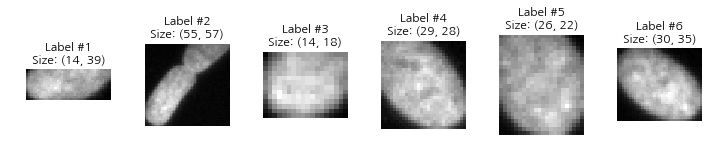

In [9]:
fig, axes = plt.subplots(1,6, figsize=(10,6))

for ii, obj_indices in enumerate(ndimage.find_objects(labels)[0:6]):
    cell = im_gray[obj_indices]
    axes[ii].imshow(cell, cmap='gray')
    axes[ii].axis('off')
    axes[ii].set_title('Label #{}\nSize: {}'.format(ii+1, cell.shape))

plt.tight_layout()
plt.show()

label#2에는 "인접 셀"문제가 있습니다. 두 셀은 같은 대상의 일부로 간주됩니다. 여기서 할 수있는건 마스크를 축소하여 셀 간의 차이를 "열 수 있는지"여부입니다. 이를 마스크 침식이라고합니다. 그런 다음 원래의 비율을 회복하기 위해 다시 확장 할 수 있습니다.

In [10]:
# 두 셀간의 객체의 인덱스를 얻고 
# 셀 마스크를 바이너리화하여 열어 봅니다.
two_cell_indices = ndimage.find_objects(labels)[1]
cell_mask = mask[two_cell_indices]
cell_mask_opened = ndimage.binary_opening(cell_mask, iterations=8)

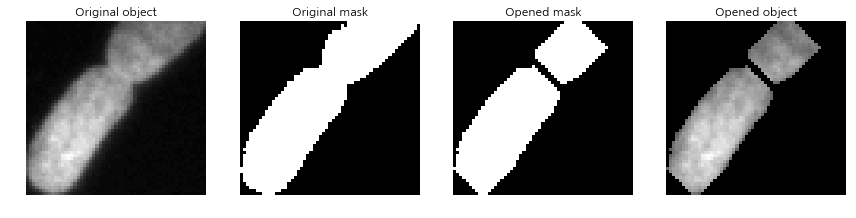

In [11]:
fig, axes = plt.subplots(1,4, figsize=(12,4))

axes[0].imshow(im_gray[two_cell_indices], cmap='gray')
axes[0].set_title('Original object')
axes[1].imshow(mask[two_cell_indices], cmap='gray')
axes[1].set_title('Original mask')
axes[2].imshow(cell_mask_opened, cmap='gray')
axes[2].set_title('Opened mask')
axes[3].imshow(im_gray[two_cell_indices]*cell_mask_opened, cmap='gray')
axes[3].set_title('Opened object')


for ax in axes:
    ax.axis('off')
plt.tight_layout()
plt.show()

### Convert each labeled object to Run Line Encoding
[Fast Run-Length Encoding (Python) - Kaggle](https://www.kaggle.com/rakhlin/fast-run-length-encoding-python)

기본적으로 배열을 통해 마스크의 일부인 픽셀을 찾을 때 인덱스를 만들고 다음 픽셀도 마스크의 일부인지 계산합니다. 
새로운 픽셀 시작점마다 이 작업을 반복합니다.

In [12]:
# from : https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
def rle_encoding(x):
    '''
    x: numpy array of shape (height, width), 1 - mask, 0 - background
    Returns run length as list
    '''
    dots = np.where(x.T.flatten()==1)[0] # .T sets Fortran order down-then-right
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b+1, 0))
        run_lengths[-1] += 1
        prev = b
    return " ".join([str(i) for i in run_lengths])

print('RLE Encoding for the current mask is: {}'.format(rle_encoding(label_mask)))

RLE Encoding for the current mask is: 210075 6 210593 8 211112 9 211631 10 212150 11 212669 12 213189 12 213709 12 214228 13 214748 13 215268 13 215788 13 216308 13 216828 13 217348 13 217869 12 218389 12 218909 12 219430 11 219950 11 220471 10 220991 10 221512 9 222033 8 222554 7 223075 6 223596 5 224117 4 224639 2


### Combine it into a single function 단일기능으로 결합

이미지를 무식하게 처리하는 단계를 거쳤기 때문에 이제 하나로 결합할 수 있습니다. 
각 마스크에 대해 RLE 문자열을 사용하여 데이터프레임을 추출합니다. 
또한 데이터세트의 모든 이미지에 대해 단일 데이터프레임을 출력하는 래퍼 함수를 구현합니다.

In [13]:
import pandas as pd

def analyze_image(im_path):
    '''
    Take an image_path (pathlib.Path object), preprocess and label it, extract the RLE strings 
    and dump it into a Pandas DataFrame.
    image_path (pathlib.Path 객체)를 가져 와서 전처리하고 레이블을 지정하고 RLE 문자열을 추출합니다.
    Pandas DataFrame에 덤프합니다.
    '''
    # Read in data and convert to grayscale
    # 데이터를 읽어 그레이스케일로 변환합니다.
    im_id = im_path.parts[-3]
    im = imageio.imread(str(im_path))
    im_gray = rgb2gray(im)
    
    # Mask out background and extract connected objects
    # 배경을 마스크 아웃하고 연결된 객체를 추출합니다.
    thresh_val = threshold_otsu(im_gray)
    mask = np.where(im_gray > thresh_val, 1, 0)
    if np.sum(mask==0) < np.sum(mask==1):
        mask = np.where(mask, 0, 1)    
        labels, nlabels = ndimage.label(mask)
    labels, nlabels = ndimage.label(mask)
    
    # Loop through labels and add each to a DataFrame
    # 레이블을 반복하고 데이터프레임에 추가합니다.
    im_df = pd.DataFrame()
    for label_num in range(1, nlabels+1):
        label_mask = np.where(labels == label_num, 1, 0)
        if label_mask.flatten().sum() > 10:
            rle = rle_encoding(label_mask)
            s = pd.Series({'ImageId': im_id, 'EncodedPixels': rle})
            im_df = im_df.append(s, ignore_index=True)
    
    return im_df


def analyze_list_of_images(im_path_list):
    '''
    Takes a list of image paths (pathlib.Path objects), analyzes each,
    and returns a submission-ready DataFrame.
    이미지 경로 (pathlib.Path 객체)의 목록을 가져 와서 각각을 분석하고,
    제출 준비가 완료된 DataFrame을 반환합니다.
    '''
    all_df = pd.DataFrame()
    for im_path in im_path_list:
        im_df = analyze_image(im_path)
        all_df = all_df.append(im_df, ignore_index=True)
    
    return all_df

In [14]:
testing = pathlib.Path('data/stage1_test/').glob('*/images/*.png')
testing

<generator object Path.glob at 0x114e86c50>

In [15]:
df = analyze_list_of_images(list(testing))
df

""


In [16]:
submit = df.to_csv('data/submission.csv', index=None)
submit